In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from urllib.request import urlopen
from urllib.error import HTTPError
from wordcloud import STOPWORDS
from wordcloud import wordcloud as WD
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import csv

In [2]:

def get_noticias(url, keywords):
    """
    Função que coleta notícias de uma página específica baseada em palavras-chave nos links.
    Também coleta a data de publicação, se disponível.
    """
    noticias = []
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.encoding = response.apparent_encoding  # Ajuste para decodificação correta
        soup = BeautifulSoup(response.content, "html.parser")

        # Encontrar todos os links na página
        links = soup.find_all('a', href=True)

        # Filtrar e armazenar apenas os links que contêm as palavras-chave
        for link_tag in links:
            link = link_tag['href']
            title = link_tag.get_text(strip=True)
            
            # Verificar se a palavra-chave está no link ou no título
            if any(keyword in link.lower() for keyword in keywords):
                # Se o link não é absoluto, fazê-lo absoluto
                if not link.startswith('http'):
                    link = urljoin(url, link)

                # Tentar capturar a data de publicação da notícia
                date = 'Data não disponível'
                try:
                    date_tag = soup.find('time')  # Se houver uma tag <time> na página
                    if date_tag and date_tag.has_attr('datetime'):
                        date = date_tag['datetime']
                    else:
                        # Tentativa alternativa, por exemplo, se a data estiver em um <span> com uma classe específica
                        date_tag = soup.find('span', class_='data-publicacao')
                        date = date_tag.get_text(strip=True) if date_tag else 'Data não disponível'
                except Exception:
                    pass

                # Adicionar a notícia à lista, incluindo a data
                if title:
                    noticias.append({"title": title, "link": link, "date": date})
    
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar {url}: {e}")
    
    return noticias

def crawl_site(url, base_url, keywords, depth=3):
    """
    Função recursiva para percorrer todo o site, coletando notícias relevantes.
    Agora coleta a data da notícia.
    """
    visited_links = set()
    noticias = []

    def _crawl(url, current_depth):
        # Verificar se o link já foi visitado ou se a profundidade máxima foi atingida
        if current_depth == 0 or url in visited_links:
            return
        
        visited_links.add(url)  # Marcar o link como visitado
        noticias_atual = get_noticias(url, keywords)

        # Remover links duplicados antes de adicionar à lista de notícias
        for noticia in noticias_atual:
            if noticia["link"] not in {n["link"] for n in noticias}:
                noticias.append(noticia)

        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.encoding = response.apparent_encoding
            soup = BeautifulSoup(response.content, "html.parser")

            # Encontrar todos os links na página e seguir
            links = soup.find_all('a', href=True)

            for link_tag in links:
                link = link_tag['href']
                if not link.startswith('http'):
                    link = urljoin(base_url, link)

                # Verificar se o link é interno e não foi visitado
                if base_url in link and link not in visited_links:
                    _crawl(link, current_depth - 1)

        except requests.exceptions.RequestException as e:
            print(f"Erro ao acessar {url}: {e}")

    _crawl(url, depth)
    return noticias

def get_text(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        response.encoding = response.apparent_encoding
        soup = BeautifulSoup(response.content, 'html.parser')

        for script in soup(['script', 'style']):
            script.extract()

        text = soup.get_text()

        lines = (line.strip() for line in text.splitlines())

        chunks = (phrase.strip() for line in lines for phrase in line.split())

        text = ' '.join(chunk for chunk in chunks if chunk)

        return text
    
    except Exception as e:
        print(f"Erro ao obter texto de {url}: {e}")
        return ""

def coluna_texto(df):
    df['corpo_texto'] = df['link'].apply(get_text)

def plot_keyword_distribution(df, keyword, color):
    filtered_df = df[df['title'].str.contains(keyword, case=False, na=False)]
    site_counts = filtered_df['Site'].value_counts()

    plt.figure(figsize=(10, 6))
    site_counts.plot(kind='bar', color=color)
    plt.title(f'Número de Links por Site Contendo "{keyword}"')
    plt.xlabel('Site')
    plt.ylabel('Número de Links')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [3]:
keywords = ["vacina", "vacinacao", "covid"]

In [4]:
base_url = "https://www1.folha.uol.com.br/equilibrioesaude/"

# Coletar notícias do site inteiro, seguindo links internos
noticias_folha = crawl_site(base_url, base_url, keywords, depth=3)

# Converter a lista de notícias em um DataFrame do pandas
df_folha = pd.DataFrame(noticias_folha)

# Remover títulos duplicados
df_folha = df_folha.drop_duplicates(subset='title')

df_folha['Site'] = 'Folha'

# Adicionar a coluna 'full_text' com o texto completo extraído de cada link
coluna_texto(df_folha)

# Exibir o DataFrame filtrado
df_folha

# Caminho e nome do arquivo para salvar o DataFrame em formato CSV
csv_file_path = "noticias_folha.csv"

# Salvar o DataFrame como um arquivo CSV
df_folha.to_csv(csv_file_path, index=False, encoding='utf-8')

In [5]:
base_url1 = 'https://g1.globo.com/fato-ou-fake/'

noticias_g1 = crawl_site(base_url1, base_url1, keywords, depth=3)

df_g1 = pd.DataFrame(noticias_g1)

df_g1['Site'] = 'Fato ou fake (G1)'

df_g1['noticia_falsa'] = '0'

coluna_texto(df_g1)

csv_file_path2 = "noticias_g1.csv"

df_g1.to_csv(csv_file_path2, index=False, encoding='utf-8')

display(df_g1)

,title,link,date,Site,noticia_falsa,corpo_texto
0,aquisição emergencial de 25 mil doses,https://agenciagov.ebc.com.br/noticias/202408/...,2024-08-20T16:41:40.382Z,Fato ou fake (G1),0,Saúde negocia aquisição de 25 mil doses de vac...
1,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1),0,É #FAKE que médicos mortos em queda de avião e...


In [6]:
base_url2 = 'https://www.gov.br/saude/pt-br'

noticias_gov = crawl_site(base_url2, base_url2, keywords, depth=3)

df_gov = pd.DataFrame(noticias_gov)

df_gov['Site'] = 'gov.br saude'

df_gov['noticia_falsa'] = '1'

def get_text2(url):
    try:
        response = requests.get(url, timeout=10)  # Adicionar timeout
        response.encoding = response.apparent_encoding  # Ajustar para a codificação correta
        soup = BeautifulSoup(response.content, features='html.parser')

        for script in soup(['script', 'style']):
            script.extract()

        text = soup.get_text()
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split(" "))
        text = ' '.join(chunk for chunk in chunks if chunk)

        # Adaptar para UTF-8, ignorando erros de codificação
        return text.encode('utf-8', errors='ignore').decode('utf-8')
    
    except (HTTPError, requests.exceptions.RequestException) as e:
        print(f"Erro ao acessar {url}: {e}")
        return "Erro ao carregar o texto"

def coluna_texto(df):
    df['corpo_texto'] = df['link'].apply(get_text2)

coluna_texto(df_gov)

# Salvar o DataFrame como um arquivo CSV com escapamento adequado
csv_file_path3 = "noticias_gov.csv"
df_gov.to_csv(csv_file_path3, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL, escapechar='\\')

# Exibir o DataFrame
display(df_gov)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/manuais: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/legislacao: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/assuntos/noticias/2022/dezembro/novos-lotes-mais-2-8-milhoes-de-vacinas-covid-19-bivalentes-chegaram-ao-brasil: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/assuntos/noticias/2021/dezembro/retrospectiva-2021-as-milhoes-de-vacinas-covid-19-que-trouxeram-esperanca-para-o-brasil: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)
Erro ao acessar https://www.gov.br/saude/pt-br/assuntos/noticias/2021/dezembro/saiba-quais-sao-as-orientacoes-para-a-vacinacao-de-criancas-contra-a-covid-19-em-outros-paises: HTTPSConnectionPool(host='w

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://twitter.com/share?text=Calend%C3%A1rio%20T%C3%A9cnico%20Nacional%20de%20Vacina%C3%A7%C3%A3o&url=https://www.gov.br/saude/resolveuid/cf95467238464eada7749b40f0e1e9d1: HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /share?text=Calend%C3%A1rio%20T%C3%A9cnico%20Nacional%20de%20Vacina%C3%A7%C3%A3o&url=https://www.gov.br/saude/resolveuid/cf95467238464eada7749b40f0e1e9d1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x77ad2d2cf670>, 'Connection to twitter.com timed out. (connect timeout=10)'))


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/legislacao/portaria-gm-ms-no-844-de-14-de-julho-de-2023: HTTPSConnectionPool(host='www.in.gov.br', port=443): Max retries exceeded with url: /en/web/dou/-/portaria-gm/ms-n-844-de-14-de-julho-de-2023-497045598 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x77ad2cae8d60>, 'Connection to www.in.gov.br timed out. (connect timeout=10)'))


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Erro ao acessar https://registra-rh-covid19.saude.gov.br/: HTTPSConnectionPool(host='registra-rh-covid19.saude.gov.br', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x77ad2c4423b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Erro ao acessar https:// https//antigo.saude.gov.br/images/pdf/2020/marco/04/Calendario-Vacinao-2020-Crian--a.pdf: HTTPSConnectionPool(host='%20https', port=443): Max retries exceeded with url: //antigo.saude.gov.br/images/pdf/2020/marco/04/Calendario-Vacinao-2020-Crian--a.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x77ad2c443160>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Erro ao acessar http://%20https//www.gov.br/saude/pt-br/coronavirus/vacinas/plano-nacional-de-operacionalizacao-da-vacina-contra-a-covid-19: HTTPConnectionPool(host='%20https', port=80): Max retries exceeded with u

,title,link,date,Site,noticia_falsa,corpo_texto
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude,1,Covid-19 — Ministério da Saúde Ir para o Conte...
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude,1,Vacinação — Ministério da Saúde Ir para o Cont...
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,Calendário de Vacinação — Ministério da Saúde ...
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,Calendário Técnico Nacional de Vacinação — Min...
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,gov.br saude,1,Atividades de vacinação de alta qualidade (Ava...
...,...,...,...,...,...,...
349,Compartilhe por LinkedIn,https://www.linkedin.com/shareArticle?mini=tru...,Data não disponível,gov.br saude,1,"LinkedIn Login, Sign in | LinkedIn Sign in Sig..."
350,Compartilhe por WhatsApp,https://api.whatsapp.com/send?text=https://www...,Data não disponível,gov.br saude,1,Compartilhe no WhatsApp Pular para o conteúdoP...
351,Movimento Nacional pela Vacinação,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude,1,Movimento Nacional pela vacinação — Ministério...
352,Acesse para saber como emitir o Certificado Na...,https://www.gov.br/pt-br/servicos/certificado-...,Data não disponível,gov.br saude,1,Obter o Certificado Nacional de Vacinação COVI...


In [7]:
base_url3 = 'https://www.aosfatos.org'

noticias_aosfatos = crawl_site(base_url3, base_url3, keywords, depth=3)

df_aosfatos = pd.DataFrame(noticias_aosfatos)

df_aosfatos['Site'] = 'Aos Fatos'

df_aosfatos['noticia_falsa'] = '0'

coluna_texto(df_aosfatos)

csv_file_path4 = "noticias_aosfatos.csv"

df_aosfatos.to_csv(csv_file_path4, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL, escapechar='\\')

display(df_aosfatos)

,title,link,date,Site,noticia_falsa,corpo_texto
0,"5,2 milhões de estrangeiros",https://noticias.uol.com.br/ultimas-noticias/a...,Data não disponível,Aos Fatos,0,Torre Eiffel recupera seu nível de visitas ant...
1,teorias conspiratórias,https://www.aosfatos.org/noticias/falso-vacina...,Data não disponível,Aos Fatos,0,É falso que vacina da AstraZeneca contra Covid...
2,não haverá vacinação em larga escala,https://agenciagov.ebc.com.br/noticias/202408/...,Data não disponível,Aos Fatos,0,Saúde negocia aquisição de 25 mil doses de vac...
3,prioridade,https://www.gov.br/saude/pt-br/assuntos/saude-...,Data não disponível,Aos Fatos,0,Mpox — Ministério da Saúde Ir para o Conteúdo ...
4,imunizantes contra a Mpox,https://g1.globo.com/saude/noticia/2024/08/20/...,Data não disponível,Aos Fatos,0,Como funcionam as vacinas contra mpox? | Saúde...
5,entrou com uma ação,https://www.aosfatos.org/bipe/agu-acao-telegra...,Data não disponível,Aos Fatos,0,AGU aciona Telegram na Justiça após Aos Fatos ...


In [8]:
base_url4 = 'https://g1.globo.com/saude/'

noticias_g1saude = crawl_site(base_url4, base_url4, keywords, depth=3)

df_g1saude = pd.DataFrame(noticias_g1saude)

df_g1saude['Site'] = 'G1 - Saúde'

df_g1saude['noticia_falsa'] = '1'

coluna_texto(df_g1saude)

csv_file_path5 = "noticias_g1saude.csv"

df_g1saude.to_csv(csv_file_path5, index=False, encoding='utf-8')

display(df_g1saude)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Pessoas que tomaram a vacina contra a dengue p...,https://g1.globo.com/sp/sao-jose-do-rio-preto-...,Data não disponível,G1 - Saúde,1,Pessoas que tomaram a vacina contra a dengue p...
1,"Após afetar Tóquio, atletas testam positivo pa...",https://g1.globo.com/mundo/olimpiadas/paris-20...,Data não disponível,G1 - Saúde,1,"Após afetar Tóquio, atletas testam positivo pa..."
2,O que muda na campanha de vacinação contra cov...,https://g1.globo.com/saude/noticia/2024/06/01/...,Data não disponível,G1 - Saúde,1,O que muda na campanha de vacinação contra cov...
3,Covid-19: por que descoberta de danos às 'usin...,https://g1.globo.com/sp/campinas-regiao/notici...,Data não disponível,G1 - Saúde,1,Covid-19: por que descoberta de danos às 'usin...
4,Memorial em homenagem às vítimas da Covid-19 é...,https://g1.globo.com/mg/triangulo-mineiro/noti...,Data não disponível,G1 - Saúde,1,Memorial em homenagem às vítimas da Covid-19 é...
5,Covid: Vacinação passa a ser anual para crianç...,https://g1.globo.com/saude/coronavirus/vacinas...,Data não disponível,G1 - Saúde,1,Covid: Vacinação passa a ser anual para crianç...
6,Covid longa pode causar danos a órgãos importa...,https://g1.globo.com/saude/noticia/2023/09/23/...,Data não disponível,G1 - Saúde,1,Covid longa pode causar danos a órgãos importa...
7,Brasil tem alta da Covid em onda que deve dura...,https://g1.globo.com/saude/noticia/2023/08/31/...,Data não disponível,G1 - Saúde,1,Brasil tem alta da Covid em onda que deve dura...
8,Covid: variante Éris é confirmada pela 1ª vez ...,https://g1.globo.com/saude/coronavirus/noticia...,Data não disponível,G1 - Saúde,1,Covid: variante Éris é confirmada pela 1ª vez ...
9,Fabricante de vacina contra mpox quer ampliar ...,https://g1.globo.com/saude/noticia/2024/08/16/...,2024-09-14T14:11:02.883Z,G1 - Saúde,1,Fabricante de vacina contra mpox quer ampliar ...


In [9]:
base_url5 = 'https://www.saude.gov.br/fakenews'

noticias_govfake = crawl_site(base_url5, base_url5, keywords, depth=3)

df_govfake = pd.DataFrame(noticias_govfake)

df_govfake['Site'] = 'Gov - Fake'

df_govfake['noticia_falsa'] = '0'

coluna_texto(df_govfake)

csv_file_path6 = "noticias_govfake.csv"

df_govfake.to_csv(csv_file_path6, index=False, encoding='utf-8')

display(df_govfake)

Erro ao acessar https://www.gov.br/saude/pt-br/vacinacao/viajantes: HTTPSConnectionPool(host='www.gov.br', port=443): Read timed out. (read timeout=10)


,title,link,date,Site,noticia_falsa,corpo_texto
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,Gov - Fake,0,Covid-19 — Ministério da Saúde Ir para o Conte...
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,Gov - Fake,0,Vacinação — Ministério da Saúde Ir para o Cont...
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake,0,Calendário de Vacinação — Ministério da Saúde ...
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake,0,Calendário Técnico Nacional de Vacinação — Min...
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,Gov - Fake,0,Atividades de vacinação de alta qualidade (Ava...
5,Distribuição de Imunobiológicos,https://www.gov.br/saude/pt-br/vacinacao/distr...,Data não disponível,Gov - Fake,0,Distribuição de Imunobiológicos — Ministério d...
6,Segurança das Vacinas,https://www.gov.br/saude/pt-br/vacinacao/esavi,Data não disponível,Gov - Fake,0,Eventos Supostamente Atribuíveis à Vacinação o...
7,Vacinas para Grupos Especiais,https://www.gov.br/saude/pt-br/vacinacao/grupo...,Data não disponível,Gov - Fake,0,Vacinas para grupos especiais — Ministério da ...
8,Vacinação para os Viajantes,https://www.gov.br/saude/pt-br/vacinacao/viaja...,Data não disponível,Gov - Fake,0,Erro ao carregar o texto
9,Rede de Frio,https://www.gov.br/saude/pt-br/vacinacao/rede-...,Data não disponível,Gov - Fake,0,Rede de Frio — Ministério da Saúde Ir para o C...


In [10]:
base_url6 = 'https://www.boatos.org'

noticias_boatos = crawl_site(base_url6, base_url6, keywords, depth=3)

df_boatos = pd.DataFrame(noticias_boatos)

df_boatos['Site'] = 'boatos.org'

df_boatos['noticia_falsa'] = '0'

coluna_texto(df_boatos)

csv_file_path7 = "noticias_boatos.csv"

df_boatos.to_csv(csv_file_path7, index=False, encoding='utf-8')

display(df_boatos)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Fake news sobre nanobots em vacinas contra Cov...,https://www.boatos.org/saude/nanobots-foram-en...,2024-09-11T18:57:18-03:00,boatos.org,0,Nanobots foram encontrados em milhões de pesso...
1,Fake news: Dr. Charles Hoffe está certo ao diz...,https://www.boatos.org/fast-checking/fake-news...,2023-12-09T16:49:49-03:00,boatos.org,0,Fake news: Dr. Charles Hoffe está certo ao diz...


In [11]:
base_url7 = 'https://brasilpopular.com'

noticias_braspop = crawl_site(base_url7, base_url7, keywords, depth=3)

df_braspop = pd.DataFrame(noticias_braspop)

df_braspop['Site'] = 'Pop Time'

coluna_texto(df_braspop)

csv_file_path8 = "noticias_braspop.csv"

df_braspop.to_csv(csv_file_path8, index=False, encoding='utf-8')

display(df_braspop)

,title,link,date,Site,corpo_texto
0,“Pandemia” de bets avançou mais rápido que sur...,https://brasilpopular.com/pandemia-de-bets-ava...,2024-09-13T17:00:00-03:00,Pop Time,"""Pandemia"" de bets avançou mais rápido que sur..."
1,"EDITORIAL – Covid, governo liberal, judiciário...",https://brasilpopular.com/editorial-covid-gove...,Data não disponível,Pop Time,"EDITORIAL - Covid, governo liberal, judiciário..."
2,“Desinformação sobre vacina segue sem punição”...,https://brasilpopular.com/desinformacao-sobre-...,Data não disponível,Pop Time,"""Desinformação sobre vacina segue sem punição""..."
3,Goiás começa a vacinar crianças de 10 e 11 ano...,https://brasilpopular.com/goias-comeca-a-vacin...,Data não disponível,Pop Time,Goiás começa a vacinar crianças de 10 e 11 ano...
4,Importância da campanha de vacinação em escola...,https://brasilpopular.com/importancia-da-campa...,Data não disponível,Pop Time,Importância da campanha de vacinação em escola...
5,Covid: taxa de transmissibilidade está em qued...,https://brasilpopular.com/covid-taxa-de-transm...,Data não disponível,Pop Time,Covid: taxa de transmissibilidade está em qued...
6,RN é o terceiro estado no Brasil que mais vaci...,https://brasilpopular.com/rn-e-o-terceiro-esta...,Data não disponível,Pop Time,RN é o terceiro estado no Brasil que mais vaci...
7,Zanin suspende decretos que dispensavam vacina...,https://brasilpopular.com/zanin-suspende-decre...,Data não disponível,Pop Time,Zanin suspende decretos que dispensavam vacina...
8,Tocantins não chega a 10% da população imuniza...,https://brasilpopular.com/tocantins-nao-chega-...,Data não disponível,Pop Time,Tocantins não chega a 10% da população imuniza...
9,Muricilândia é o 1º município tocantinense a v...,https://brasilpopular.com/muricilandia-e-o-1o-...,Data não disponível,Pop Time,Muricilândia é o 1º município tocantinense a v...


In [12]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/falso-2/page/"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsafalso = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsafalso.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsafalso = pd.DataFrame(noticias_efarsafalso)

# Remover títulos duplicados
df_efarsafalso = df_efarsafalso.drop_duplicates(subset='title')

df_efarsafalso['Site'] = 'E-Farsas (Falso)'

df_efarsafalso['noticia_falsa'] = '0'

coluna_texto(df_efarsafalso)

# Exibir o DataFrame filtrado
csv_file_path9 = "noticias_efarsafake.csv"

df_efarsafalso.to_csv(csv_file_path9, index=False, encoding='utf-8')

display(df_efarsafalso)

,title,link,date,Site,noticia_falsa,corpo_texto
0,É verdade que o número 95004-1117 aplica o gol...,http://www.e-farsas.com/e-verdade-que-o-numero...,Data não disponível,E-Farsas (Falso),0,É verdade que o número 95004-1117 aplica o gol...
1,A Pfizer mudou de nome para Viatris para não s...,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,Data não disponível,E-Farsas (Falso),0,A Pfizer mudou de nome para Viatris para não s...
2,Homem dado como morto pela COVID em Parauapeba...,http://www.e-farsas.com/homem-dado-como-morto-...,Data não disponível,E-Farsas (Falso),0,Homem dado como morto pela COVID em Parauapeba...
3,Uma patente para um teste de COVID-19 foi feit...,http://www.e-farsas.com/uma-patente-para-um-te...,Data não disponível,E-Farsas (Falso),0,Uma patente para um teste de COVID-19 foi feit...
4,O menino Luca morreu de parada cardíaca após s...,http://www.e-farsas.com/o-menino-luca-morreu-d...,Data não disponível,E-Farsas (Falso),0,O menino Luca morreu de parada cardíaca após s...
...,...,...,...,...,...,...
57,Uma jovem de 17 anos morreu por causa da vacin...,http://www.e-farsas.com/uma-jovem-de-17-anos-m...,Data não disponível,E-Farsas (Falso),0,Uma jovem de 17 anos morreu por causa da vacin...
58,A vacina contra a febre amarela é um veneno mo...,http://www.e-farsas.com/vacina-contra-febre-am...,Data não disponível,E-Farsas (Falso),0,A vacina contra a febre amarela é um veneno mo...
59,Vacina contra a rubéola foi a causa da microce...,http://www.e-farsas.com/vacina-contra-a-rubeol...,Data não disponível,E-Farsas (Falso),0,Vacina contra a rubéola foi a causa da microce...
60,Vacina anticâncer rins e pele! Noticia boa (se...,http://www.e-farsas.com/vacina-anticancer-rins...,Data não disponível,E-Farsas (Falso),0,Vacina anticâncer rins e pele! Noticia boa (se...


In [13]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/verdadeiro-2/page"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsaverdadeiro = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsaverdadeiro.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsaverdadeiro = pd.DataFrame(noticias_efarsaverdadeiro)

# Remover títulos duplicados
df_efarsaverdadeiro = df_efarsaverdadeiro.drop_duplicates(subset='title')

df_efarsaverdadeiro['Site'] = 'E-Farsas (Verdadeiros)'

df_efarsaverdadeiro['noticia_falsa'] = '1'

coluna_texto(df_efarsaverdadeiro)

# Exibir o DataFrame filtrado
csv_file_path10 = "noticias_efarsatrue.csv"

df_efarsaverdadeiro.to_csv(csv_file_path10, index=False, encoding='utf-8')

display(df_efarsaverdadeiro)

,title,link,date,Site,noticia_falsa,corpo_texto
0,O governo do Vietnã está arrancando à força as...,http://www.e-farsas.com/o-governo-do-vietna-es...,Data não disponível,E-Farsas (Verdadeiros),1,O governo do Vietnã está arrancando à força as...
1,Imagem mostra poucas mortes por COVID em paíse...,http://www.e-farsas.com/imagem-mostra-poucas-m...,Data não disponível,E-Farsas (Verdadeiros),1,Imagem mostra poucas mortes por COVID em paíse...
2,Decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros),1,Decathlon recomendou que pessoas do grupo de r...
3,Governo do Maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros),1,Governo do Maranhão vem fornecendo kits com cl...
4,“Kit COVID-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros),1,"""Kit COVID-19"" para combater o novo coronavíru..."
5,"Autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros),1,"Autoridades, parem de distorcer fatos sobre a ..."
6,É verdade que um defensor do movimento antivac...,http://www.e-farsas.com/e-verdade-que-um-defen...,Data não disponível,E-Farsas (Verdadeiros),1,É verdade que um defensor do movimento antivac...


In [14]:
base_urlmpv = 'https://medicospelavidacovid19.com.br'

noticias_mpv = crawl_site(base_urlmpv, base_urlmpv, keywords, depth=3)

df_mpv = pd.DataFrame(noticias_mpv)

df_mpv['Site'] = 'Médicos Pela Vida'

df_mpv['noticia_falsa'] = '0'

coluna_texto(df_mpv)

csv_file_pathmpv = "noticias_mpv.csv"

df_mpv.to_csv(csv_file_pathmpv, index=False, encoding='utf-8')

display(df_mpv)

Erro ao acessar https://twitter.com/mpvcovid19: HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /mpvcovid19 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x77ad2cb10dc0>, 'Connection to twitter.com timed out. (connect timeout=10)'))
Erro ao acessar https://rumble.com/user/medicospelavidacovid19: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Erro ao acessar mailto:contato@medicospelavidacovid19.com.br: No connection adapters were found for 'mailto:contato@medicospelavidacovid19.com.br'


,title,link,date,Site,noticia_falsa,corpo_texto
0,HOME,https://medicospelavidacovid19.com.br/,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,Home Skip to content HOME ÚLTIMAS EDITORIAIS A...
1,ÚLTIMAS,https://medicospelavidacovid19.com.br/ultimas/,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,Últimas Skip to content HOME ÚLTIMAS EDITORIAI...
2,EDITORIAIS,https://medicospelavidacovid19.com.br/editoriais/,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,Editoriais Skip to content HOME ÚLTIMAS EDITOR...
3,ARTIGOS,https://medicospelavidacovid19.com.br/artigos/,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,Artigos Skip to content HOME ÚLTIMAS EDITORIAI...
4,ESTUDOS,https://medicospelavidacovid19.com.br/estudos/,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,Estudos Skip to content HOME ÚLTIMAS EDITORIAI...
...,...,...,...,...,...,...
227,anunciado previamente,https://www.nytimes.com/2023/09/26/well/live/c...,2024-04-09T10:12:10-03:00,Médicos Pela Vida,0,nytimes.comPlease enable JS and disable any ad...
228,R$ 5 mil,https://www1.folha.uol.com.br/equilibrioesaude...,2024-04-09T10:12:10-03:00,Médicos Pela Vida,0,"Preço do Paxlovid, para Covid, chega a quase R..."
229,demonstrou reduzir,https://medicospelavidacovid19.com.br/noticias...,2024-04-09T10:12:10-03:00,Médicos Pela Vida,0,Estudo definitivo comprova eficácia da vitamin...
230,já demonstrou,https://medicospelavidacovid19.com.br/noticias...,2024-04-09T10:12:10-03:00,Médicos Pela Vida,0,Baixos níveis de vitamina D estão associados à...


In [15]:
dataframes = [df_efarsafalso, df_mpv, df_govfake, df_g1, df_boatos]

df_combinedfake = pd.concat(dataframes, ignore_index=True)

csv_file_path11 = "noticias_combinedfake.csv"

df_combinedfake.to_csv(csv_file_path11, index=False, encoding='utf-8')

display(df_combinedfake)

,title,link,date,Site,noticia_falsa,corpo_texto
0,É verdade que o número 95004-1117 aplica o gol...,http://www.e-farsas.com/e-verdade-que-o-numero...,Data não disponível,E-Farsas (Falso),0,É verdade que o número 95004-1117 aplica o gol...
1,A Pfizer mudou de nome para Viatris para não s...,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,Data não disponível,E-Farsas (Falso),0,A Pfizer mudou de nome para Viatris para não s...
2,Homem dado como morto pela COVID em Parauapeba...,http://www.e-farsas.com/homem-dado-como-morto-...,Data não disponível,E-Farsas (Falso),0,Homem dado como morto pela COVID em Parauapeba...
3,Uma patente para um teste de COVID-19 foi feit...,http://www.e-farsas.com/uma-patente-para-um-te...,Data não disponível,E-Farsas (Falso),0,Uma patente para um teste de COVID-19 foi feit...
4,O menino Luca morreu de parada cardíaca após s...,http://www.e-farsas.com/o-menino-luca-morreu-d...,Data não disponível,E-Farsas (Falso),0,O menino Luca morreu de parada cardíaca após s...
...,...,...,...,...,...,...
311,Saúde inicia campanha de vacinação contra a gr...,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,Gov - Fake,0,Ministério da Saúde inicia campanha de vacinaç...
312,aquisição emergencial de 25 mil doses,https://agenciagov.ebc.com.br/noticias/202408/...,2024-08-20T16:41:40.382Z,Fato ou fake (G1),0,Saúde negocia aquisição de 25 mil doses de vac...
313,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1),0,É #FAKE que médicos mortos em queda de avião e...
314,Fake news sobre nanobots em vacinas contra Cov...,https://www.boatos.org/saude/nanobots-foram-en...,2024-09-11T18:57:18-03:00,boatos.org,0,Nanobots foram encontrados em milhões de pesso...


In [16]:
dataframes = [df_gov, df_g1saude, df_efarsaverdadeiro]

df_combinedtrue = pd.concat(dataframes, ignore_index=True)

csv_file_path12 = "noticias_combinedtrue.csv"

df_combinedtrue.to_csv(csv_file_path12, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL, escapechar='\\')

display(df_combinedtrue)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude,1,Covid-19 — Ministério da Saúde Ir para o Conte...
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude,1,Vacinação — Ministério da Saúde Ir para o Cont...
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,Calendário de Vacinação — Ministério da Saúde ...
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,Calendário Técnico Nacional de Vacinação — Min...
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,gov.br saude,1,Atividades de vacinação de alta qualidade (Ava...
...,...,...,...,...,...,...
371,Decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros),1,Decathlon recomendou que pessoas do grupo de r...
372,Governo do Maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros),1,Governo do Maranhão vem fornecendo kits com cl...
373,“Kit COVID-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros),1,"""Kit COVID-19"" para combater o novo coronavíru..."
374,"Autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros),1,"Autoridades, parem de distorcer fatos sobre a ..."


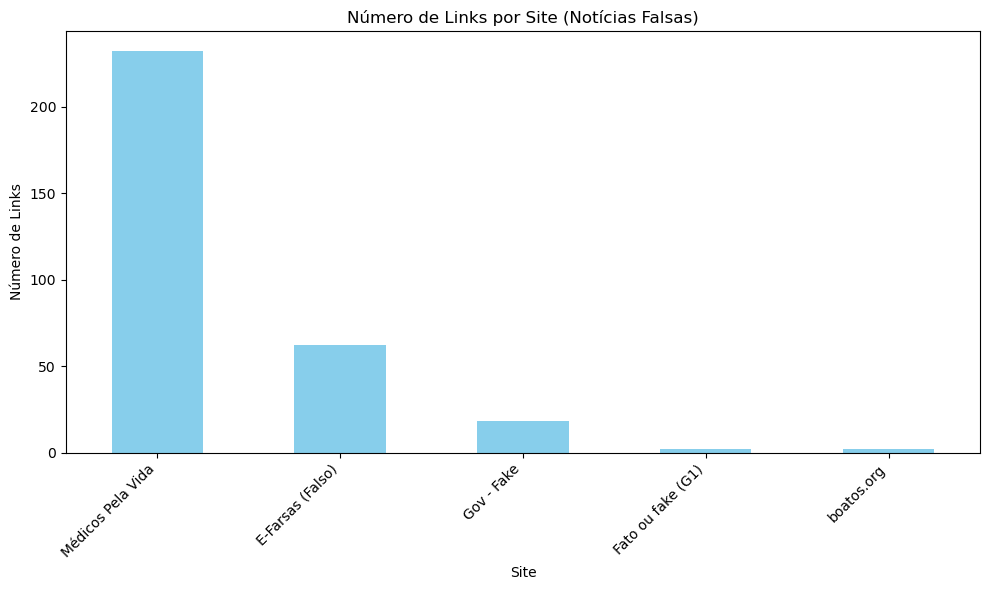

In [17]:
# Contar o número de links para cada site
site_counts = df_combinedfake['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site (Notícias Falsas)')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

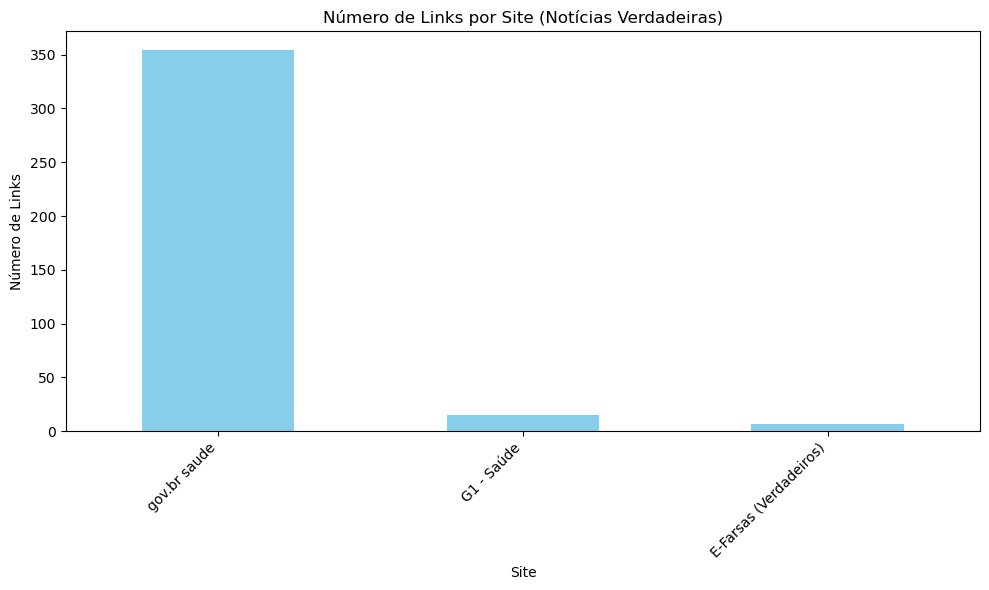

In [18]:
# Contar o número de links para cada site
site_counts = df_combinedtrue['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site (Notícias Verdadeiras)')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

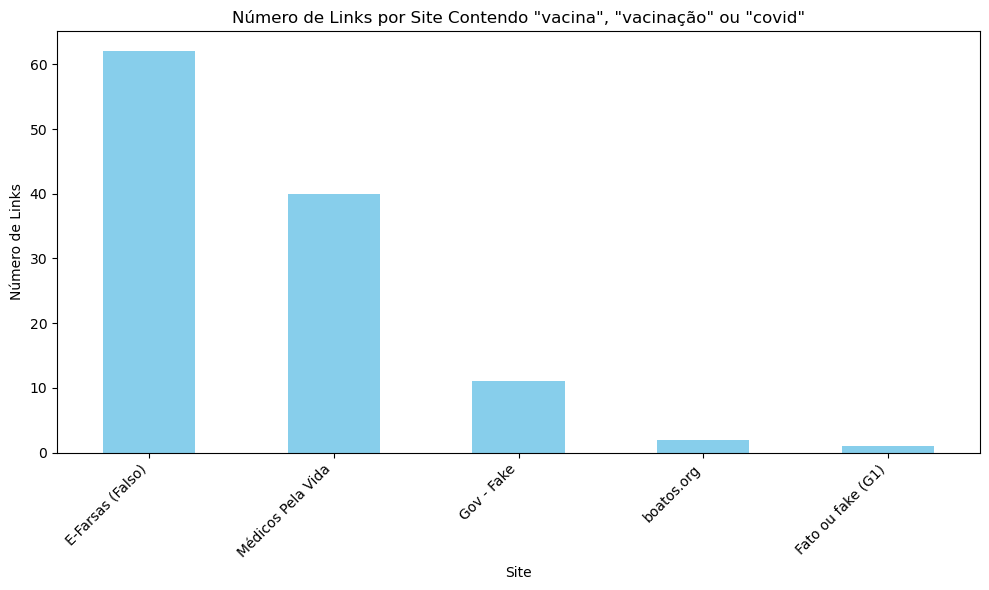

In [19]:
# Filtrar os links que contêm as palavras-chave
filtered_df = df_combinedfake[df_combinedfake['title'].str.contains('|'.join(keywords), case=False, na=False)]

# Contar o número de links para cada site
site_counts = filtered_df['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site Contendo "vacina", "vacinação" ou "covid"')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

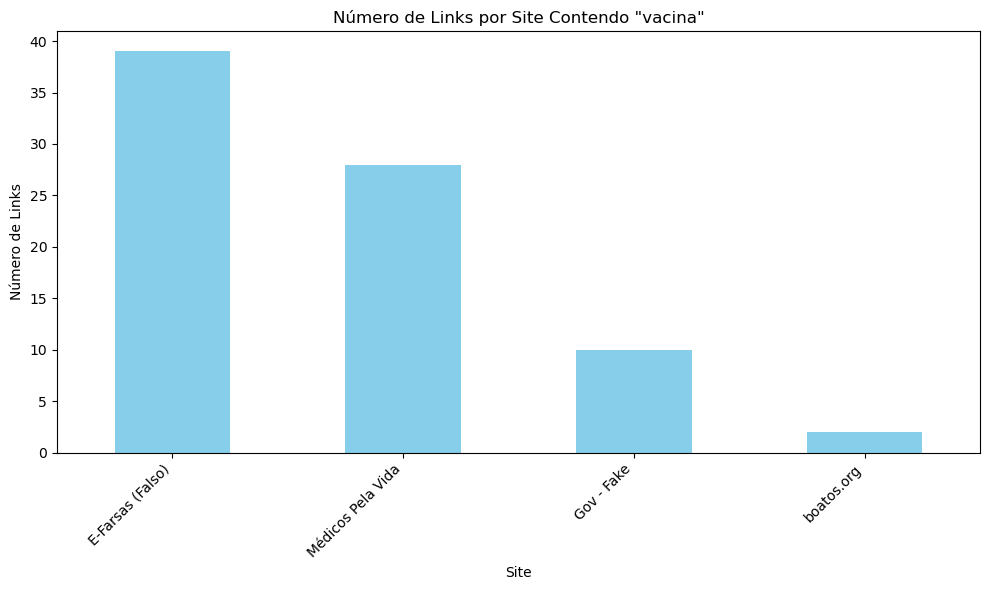

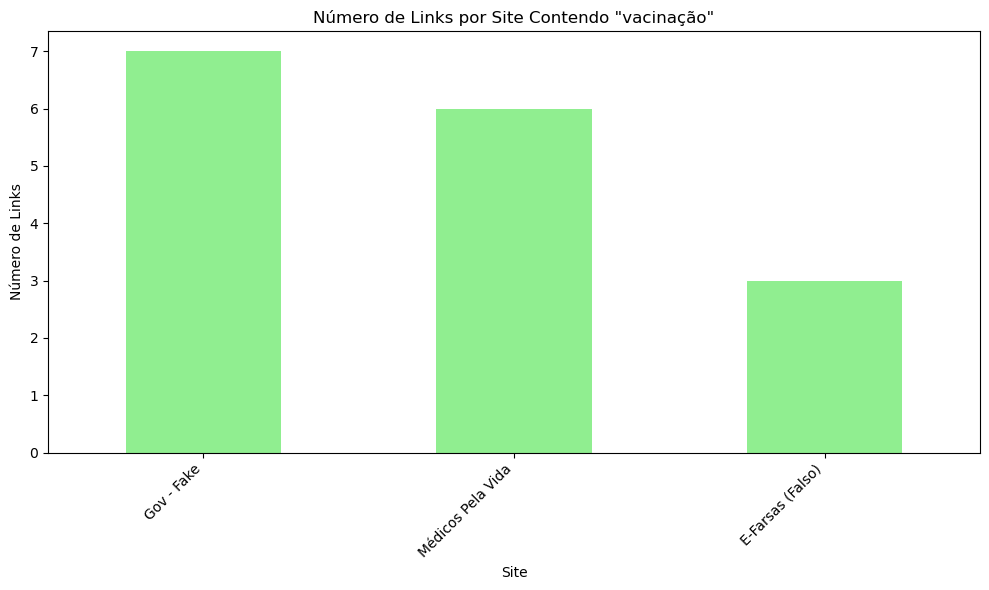

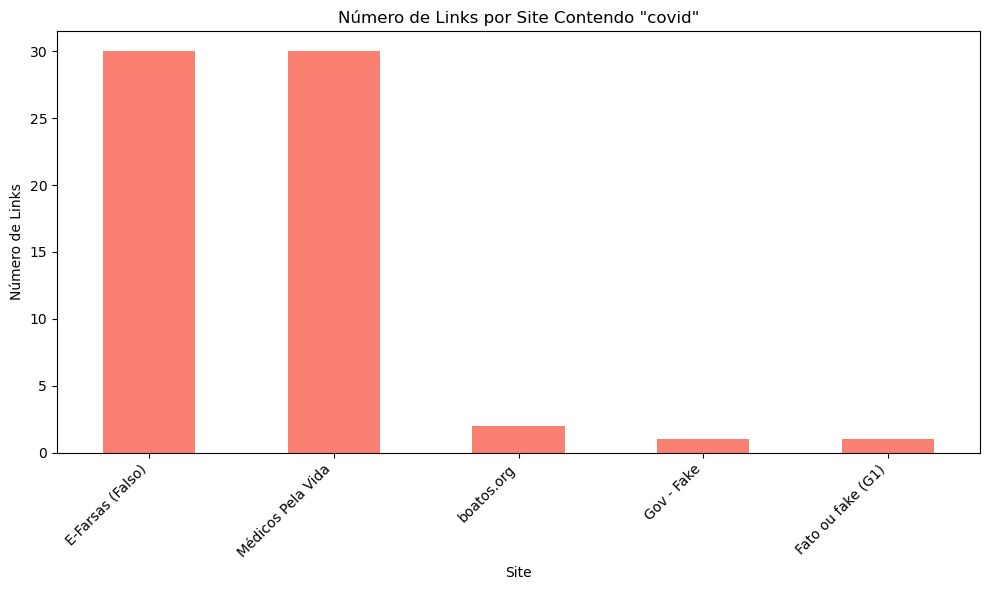

In [20]:
# Gráfico para "vacina"
plot_keyword_distribution(df_combinedfake, "vacina", 'skyblue')

# Gráfico para "vacinação"
plot_keyword_distribution(df_combinedfake, "vacinação", 'lightgreen')

# Gráfico para "covid"
plot_keyword_distribution(df_combinedfake, "covid", 'salmon')

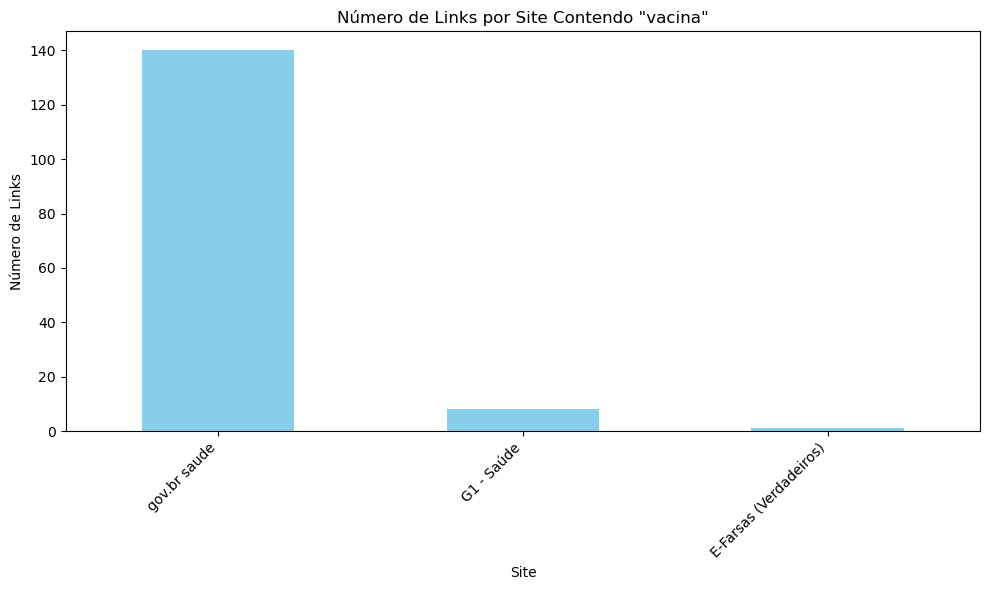

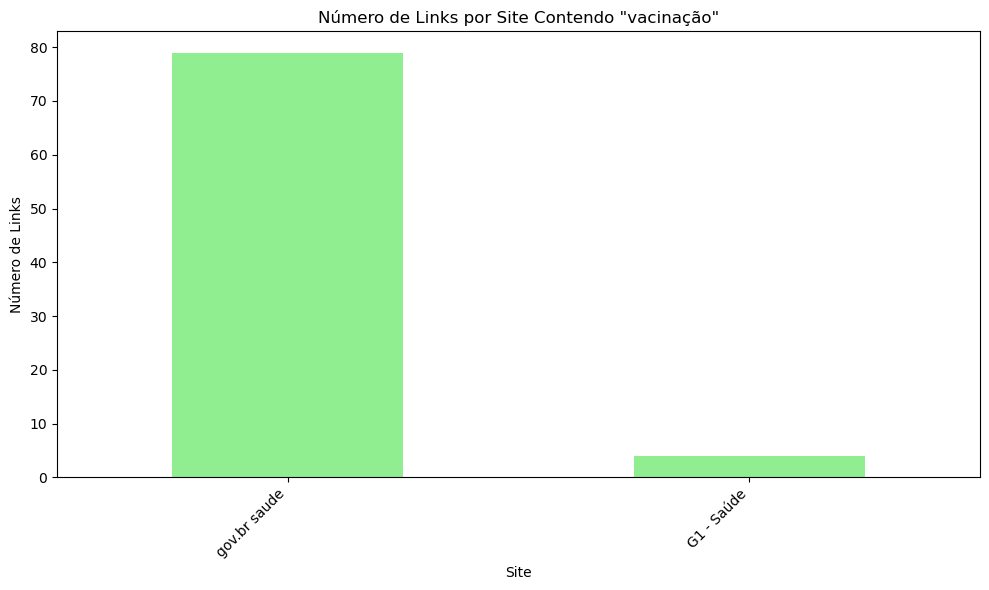

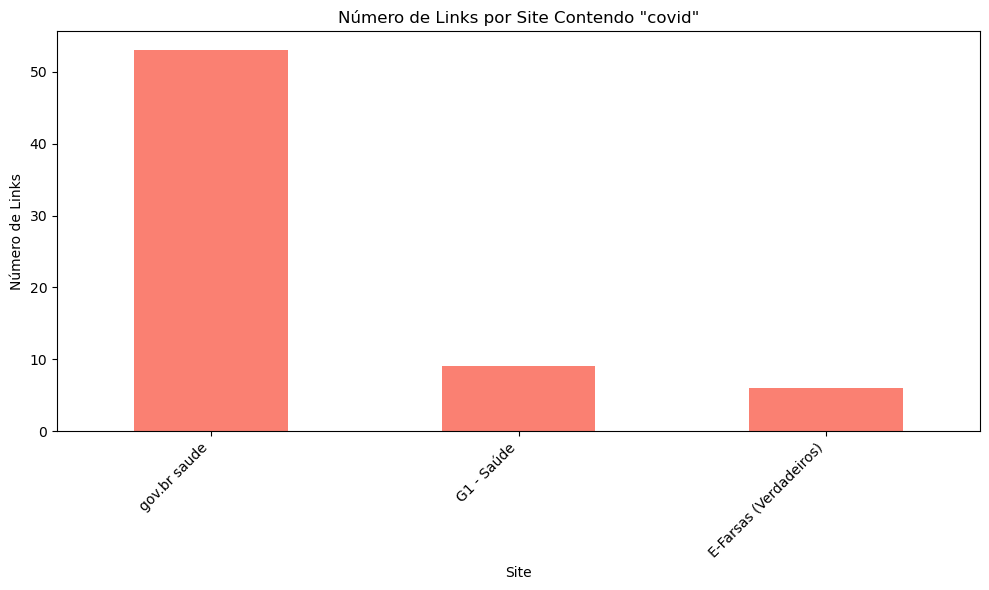

In [21]:
# Gráfico para "vacina"
plot_keyword_distribution(df_combinedtrue, "vacina", 'skyblue')

# Gráfico para "vacinação"
plot_keyword_distribution(df_combinedtrue, "vacinação", 'lightgreen')

# Gráfico para "covid"
plot_keyword_distribution(df_combinedtrue, "covid", 'salmon')

In [22]:
# Certifique-se de ter baixado as stopwords
nltk.download('stopwords')

# Lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))

def process_links_column(df):
    # Função para processar cada link
    def split_and_clean(link):
        # Dividir o link por '/', '-', '%', '.', e ':'
        words = re.split(r'[/\-\%\.\:]', link)
        # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
        unwanted = {'https', 'gov', 'www', 'com', 'br', 'pt'}
        cleaned_words = [
            word for word in words 
            if word.lower() not in stop_words 
            and not any(unwanted_word in word.lower() for unwanted_word in unwanted) 
            and len(word) > 1
        ]
        return cleaned_words
    
    # Aplicar a função a cada link na coluna 'links'
    df['processed_links'] = df['link'].apply(split_and_clean)
    return df

# Aplicar ao dataframe df_combinedtrue
df_combinedtrue = process_links_column(df_combinedtrue)

# Visualizar o resultado
df_combinedtrue[['link', 'processed_links']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ABTLUS/pedro220058/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,link,processed_links
0,https://www.gov.br/saude/pt-br/assuntos/covid-19,"[saude, assuntos, covid, 19]"
1,https://www.gov.br/saude/pt-br/vacinacao,"[saude, vacinacao]"
2,https://www.gov.br/saude/pt-br/vacinacao/calen...,"[saude, vacinacao, calendario]"
3,https://www.gov.br/saude/pt-br/vacinacao/calen...,"[saude, vacinacao, calendario, tecnico]"
4,https://www.gov.br/saude/pt-br/vacinacao/avaq,"[saude, vacinacao, avaq]"
...,...,...
371,http://www.e-farsas.com/decathlon-recomendou-q...,"[http, farsas, decathlon, pessoas, grupo, risc..."
372,http://www.e-farsas.com/governo-do-maranhao-ve...,"[http, farsas, maranhao, vem, fornecendo, kits..."
373,http://www.e-farsas.com/kit-covid-19-para-comb...,"[http, farsas, kit, covid, 19, novo, coronavir..."
374,http://www.e-farsas.com/autoridades-parem-de-d...,"[http, farsas, autoridades, parem, distorcer, ..."


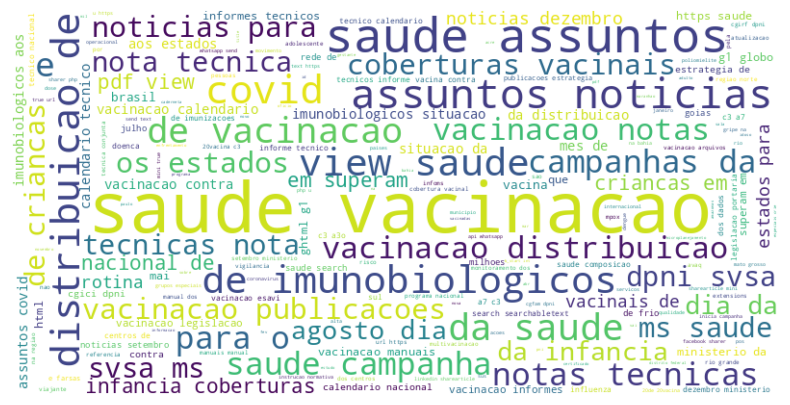

In [23]:
# Função para remover as strings indesejadas
def clean_link_text(link):
    # Separar as palavras por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:]', link)
    # Lista de palavras indesejadas para remover
    unwanted_words = {'https', 'com', 'br', 'pt', 'https:', 'www', 'gov'}
    # Filtrar as palavras, removendo as indesejadas
    cleaned_words = [word.lower() for word in words if word.lower() not in unwanted_words]
    return ' '.join(cleaned_words)

# Aplicar a função de limpeza nos links
df_combinedtrue['cleaned_links'] = df_combinedtrue['link'].apply(clean_link_text)

# Unir todos os links limpos em um único texto
text = ' '.join(df_combinedtrue['cleaned_links'])

# Remover quaisquer instâncias restantes de "gov" e "br" após a junção das palavras
unwanted_patterns = re.compile(r'\b(gov|br)\b', re.IGNORECASE)
text = unwanted_patterns.sub('', text)

# Gerar a nuvem de palavras
wordcloud = WD.WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
# Certifique-se de ter baixado as stopwords
nltk.download('stopwords')

# Lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))

def process_links_column(df):
    # Função para processar cada link
    def split_and_clean(link):
        # Dividir o link por '/', '-', '%', '.', e ':'
        words = re.split(r'[/\-\%\.\:]', link)
        # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
        unwanted = {'https', 'gov', 'www', 'com', 'br', 'pt'}
        cleaned_words = [
            word for word in words 
            if word.lower() not in stop_words 
            and not any(unwanted_word in word.lower() for unwanted_word in unwanted) 
            and len(word) > 1
        ]
        return cleaned_words
    
    # Aplicar a função a cada link na coluna 'links'
    df['processed_links'] = df['link'].apply(split_and_clean)
    return df

# Aplicar ao dataframe df_combinedtrue
df_combinedfake = process_links_column(df_combinedfake)

# Visualizar o resultado
df_combinedfake[['link', 'processed_links']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ABTLUS/pedro220058/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,link,processed_links
0,http://www.e-farsas.com/e-verdade-que-o-numero...,"[http, farsas, verdade, numero, 95004, 1117, a..."
1,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,"[http, farsas, pfizer, mudou, nome, viatris, n..."
2,http://www.e-farsas.com/homem-dado-como-morto-...,"[http, farsas, homem, dado, morto, covid, para..."
3,http://www.e-farsas.com/uma-patente-para-um-te...,"[http, farsas, patente, teste, covid, 19, feit..."
4,http://www.e-farsas.com/o-menino-luca-morreu-d...,"[http, farsas, menino, luca, morreu, parada, c..."
...,...,...
311,https://www.gov.br/saude/pt-br/assuntos/notici...,"[saude, assuntos, noticias, 2024, ministerio, ..."
312,https://agenciagov.ebc.com.br/noticias/202408/...,"[ebc, noticias, 202408, saude, negocia, aquisi..."
313,https://g1.globo.com/fato-ou-fake/campinas-e-r...,"[g1, globo, fato, fake, campinas, regiao, noti..."
314,https://www.boatos.org/saude/nanobots-foram-en...,"[boatos, org, saude, nanobots, encontrados, mi..."


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ABTLUS/pedro220058/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


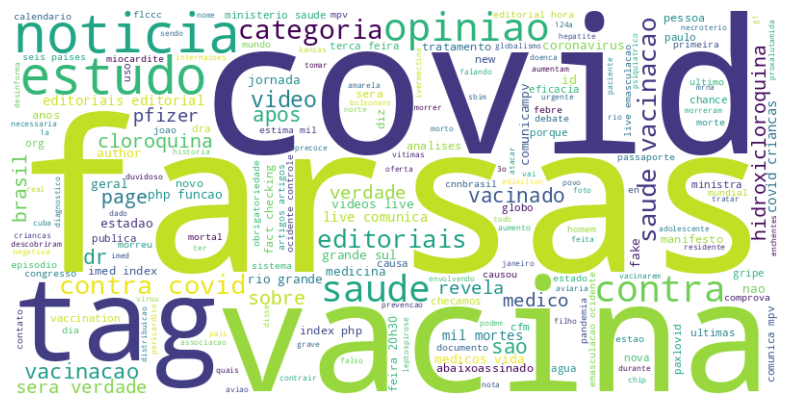

In [25]:
# Certifique-se de ter baixado as stopwords
nltk.download('stopwords')

# Lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Função para remover as strings indesejadas
def clean_link_text(link):
    # Separar as palavras por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:]', link)
    # Lista de palavras indesejadas para remover
    unwanted_words = {'https', 'com', 'br', 'pt', 'https:', 'www', 'www1', 'gov', 'shtml', 'html', 'folha', 'medicospelavidacovid19'}
    # Filtrar as palavras, removendo as indesejadas, stopwords e números
    cleaned_words = [word.lower() for word in words if word.lower() not in unwanted_words and word.lower() not in stop_words and not word.isdigit()]
    return ' '.join(cleaned_words)

# Aplicar a função de limpeza nos links
df_combinedfake['cleaned_links'] = df_combinedfake['link'].apply(clean_link_text)

# Unir todos os links limpos em um único texto
text = ' '.join(df_combinedfake['cleaned_links'])

# Remover quaisquer instâncias restantes de strings indesejadas após a junção das palavras
unwanted_patterns = re.compile(r'\b(gov|br|http|https|www|www1|shtml|html)\b', re.IGNORECASE)
text = unwanted_patterns.sub('', text)

# Gerar a nuvem de palavras
wordcloud = WD.WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


/tmp/ipykernel_5767/1418875589.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(labels), palette="viridis")


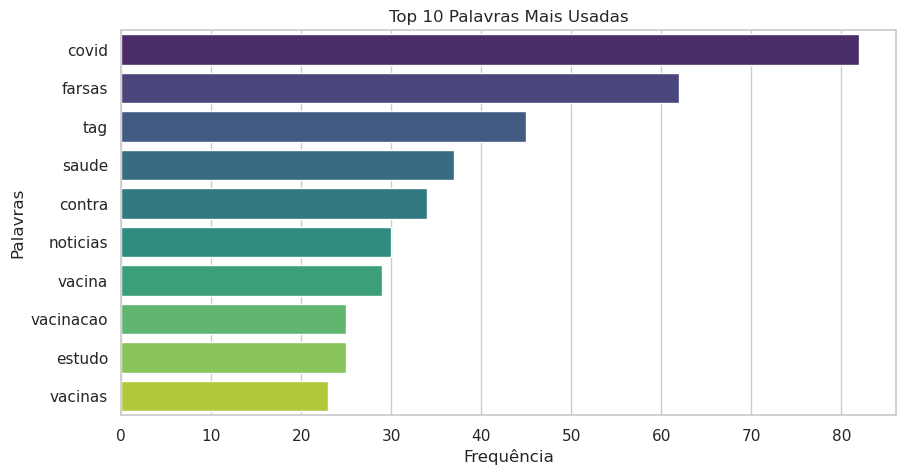

In [26]:
# Dividir o texto em palavras
words = text.split()

# Contar a frequência de cada palavra
word_counts = Counter(words)

# Selecionar as 10 palavras mais comuns
common_words = word_counts.most_common(10)

# Separar as palavras e suas frequências
labels, values = zip(*common_words)

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=list(values), y=list(labels), palette="viridis")

# Configurar título e labels
plt.title('Top 10 Palavras Mais Usadas')
plt.xlabel('Frequência')
plt.ylabel('Palavras')

# Exibir o gráfico
plt.show()